In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath("../.."))
from configs import GOOGLE_APPLICATION_CREDENTIALS,GCS_BUCKET_NAME,GCS_PROJECT_ID
from google.cloud import bigquery

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)

query = """SELECT *
FROM `khangtestdbt.xecupredict.data_done` """
data = client.query(query).to_dataframe()
data.head(1)

,km,origin,body,fuel,brand,age,price
0,110.0,nhập khẩu,hatchback,xăng,kia,18.0,125500000.0


In [4]:
df = data.copy()

In [5]:
df.head(10)

,km,origin,body,fuel,brand,age,price
0,110.0,nhập khẩu,hatchback,xăng,kia,18.0,125500000.0
1,110.0,nhập khẩu,minivan,dầu,kia,15.0,200000000.0
2,112.0,nhập khẩu,hatchback,xăng,hyundai,10.0,165000000.0
3,113.0,trong nước,sedan,xăng,kia,15.0,229250000.0
4,120.0,trong nước,suv,dầu,ford,10.0,455000000.0
5,120.0,trong nước,suv,xăng,toyota,16.0,210000000.0
6,123.0,nhập khẩu,hatchback,xăng,hyundai,11.0,149000000.0
7,123.0,nhập khẩu,sedan,xăng,daewoo,16.0,118000000.0
8,123.0,nhập khẩu,sedan,xăng,nissan,16.0,219000000.0
9,123.0,nhập khẩu,van,dầu,ford,19.0,90000000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820 entries, 0 to 4819
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   km      4820 non-null   float64
 1   origin  4820 non-null   object 
 2   body    4820 non-null   object 
 3   fuel    4820 non-null   object 
 4   brand   4820 non-null   object 
 5   age     4820 non-null   float64
 6   price   4820 non-null   float64
dtypes: float64(3), object(4)
memory usage: 263.7+ KB


In [7]:
df.describe(include="all")

,km,origin,body,fuel,brand,age,price
count,4820.000000,4820,4820,4820,4820,4820.000000,4.820000e+03
unique,NaN,2,14,4,26,NaN,NaN
top,NaN,nhập khẩu,suv,xăng,toyota,NaN,NaN
freq,NaN,2495,2197,3812,797,NaN,NaN
mean,65891.232495,NaN,NaN,NaN,NaN,6.511411,9.126718e+08
std,46276.575554,NaN,NaN,NaN,NaN,4.883502,1.153189e+09
min,110.000000,NaN,NaN,NaN,NaN,0.000000,5.200000e+07
25%,32000.000000,NaN,NaN,NaN,NaN,3.000000,3.798333e+08
50%,60000.000000,NaN,NaN,NaN,NaN,5.000000,5.700000e+08
75%,90000.000000,NaN,NaN,NaN,NaN,9.000000,9.500000e+08


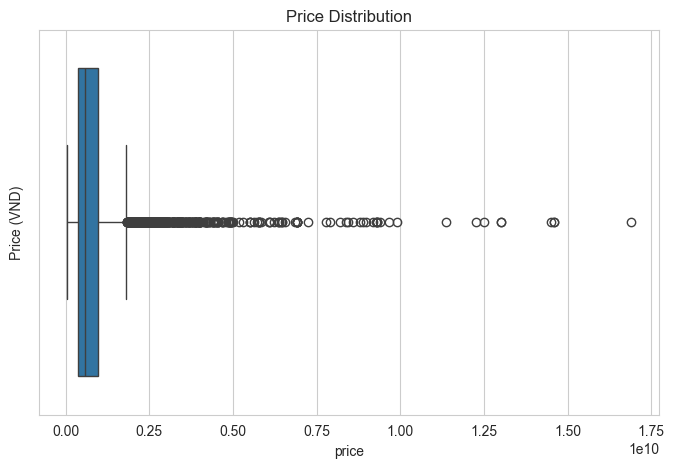

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x="price", data=df)
plt.title("Price Distribution")
plt.ylabel("Price (VND)")
plt.show()

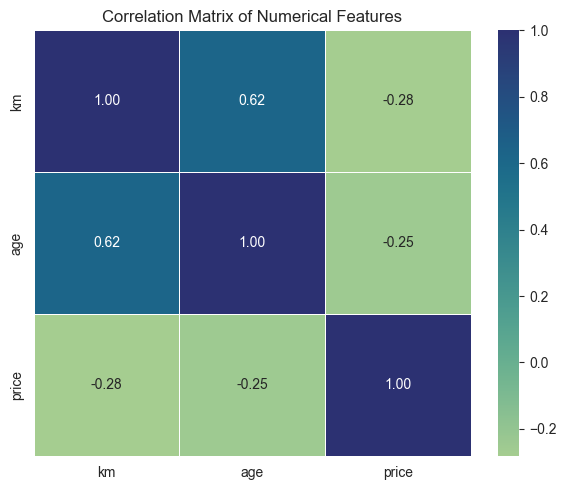

In [78]:
num_cols = ["km", "age", "price"]

corr = df[num_cols].corr()

plt.figure(figsize=(6,5))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="crest",
    linewidths=0.5
)

plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


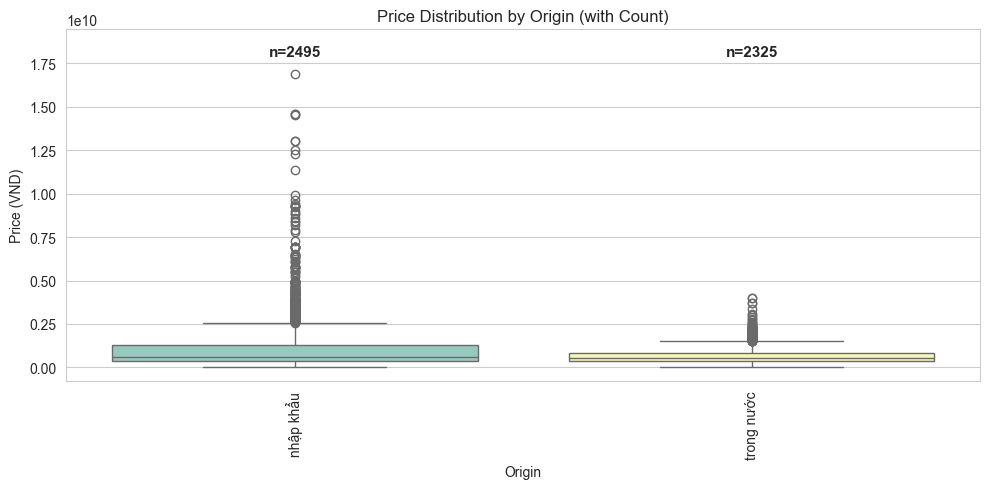

In [59]:
plt.figure(figsize=(10,5))

ax = sns.boxplot(
    x="origin",
    y="price",
    data=df,
    palette="Set3"
)

plt.title("Price Distribution by Origin (with Count)")
plt.ylabel("Price (VND)")
plt.xlabel("Origin")
plt.xticks(rotation=90)

counts = df["origin"].value_counts()

y_max = df["price"].max()

for i, origin in enumerate(ax.get_xticklabels()):
    origin_name = origin.get_text()
    count = counts[origin_name]
    
    ax.text(
        i,
        y_max * 1.05,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.ylim(top=y_max * 1.15)
plt.tight_layout()
plt.show()


## 🔍 Insight: Ảnh hưởng của Origin đến Giá Xe Cũ

### 📊 Quan sát từ dữ liệu
- Số lượng xe **nhập khẩu và trong nước gần tương đương**, đảm bảo tính công bằng khi so sánh.
- **Median giá của hai nhóm gần tương đương**, cho thấy origin không chi phối mạnh phân khúc phổ thông.
- Xe **nhập khẩu có dải giá rộng hơn**, trong khi xe **trong nước tập trung hơn và ít xe quá đắt**.
- **Q3 của xe nhập khẩu cao hơn xe trong nước** (0.25 > 0.20), đồng thời **outlier giá cao của xe nhập khẩu vượt trội**.

### 🧠 Insight chính
- **Origin ảnh hưởng mạnh ở phân khúc giá cao**, nhưng **không ảnh hưởng đáng kể đến toàn bộ phân phối giá**.
- **Các xe thuộc phân khúc cao cấp chủ yếu là xe nhập khẩu**, thể hiện rõ qua Q3 và mức giá tối đa.
- **Origin không quyết định giá trung bình**, tuy nhiên **có tác động rõ rệt ở phân khúc giá cao của thị trường xe cũ**.

---

## 🚗 Lời khuyên dành cho người mua xe

### 💸 Ngân sách trung bình
- **Origin không phải yếu tố quyết định**.

### 💎 Nhắm phân khúc cao
- **Xe nhập khẩu có nhiều lựa chọn hơn**, đặc biệt ở phân khúc cao cấp.
- Cần **kiểm tra kỹ giá trị thực** để tránh mua xe bị “thổi giá”.

### ❗ Khuyến nghị chung
- ❌ **Không nên trả giá cao chỉ vì xe nhập khẩu**.
- Xe **trong nước** có thể **giá tương đương nhưng dễ bảo dưỡng và sửa chữa hơn**.

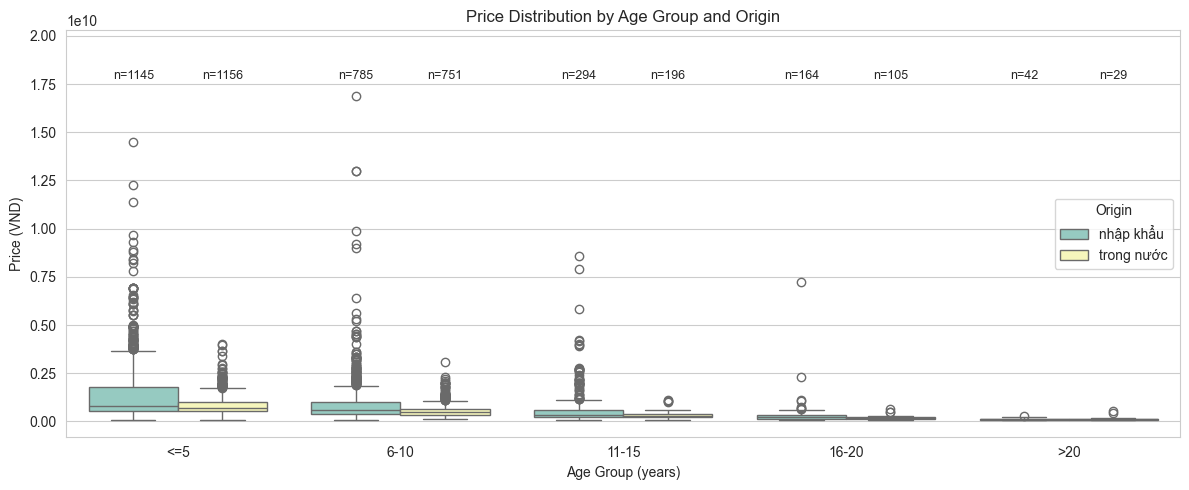

In [66]:

df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 5, 10, 15, 20, 100],
    labels=["<=5", "6-10", "11-15", "16-20", ">20"]
)

plt.figure(figsize=(12,5))

ax = sns.boxplot(
    x="age_group",
    y="price",
    hue="origin",
    data=df,
    palette="Set3"
)

plt.title("Price Distribution by Age Group and Origin")
plt.xlabel("Age Group (years)")
plt.ylabel("Price (VND)")
plt.legend(title="Origin")

counts = df.groupby(["age_group", "origin"]).size()

y_max = df["price"].max()

for i, age in enumerate(df["age_group"].cat.categories):
    for j, origin in enumerate(df["origin"].unique()):
        if (age, origin) in counts:
            ax.text(
                i + (-0.2 if j == 0 else 0.2),
                y_max * 1.05,
                f"n={counts[(age, origin)]}",
                ha="center",
                fontsize=9
            )

plt.ylim(top=y_max * 1.2)
plt.tight_layout()
plt.show()


### 🔍 Insight: Giá Xe theo Tuổi Xe và Nguồn Gốc (Origin)

- **Nhóm xe cao tuổi (>16 năm)**:  
  Giá xe **trong nước và nhập khẩu gần tương đương**, số lượng xe được bán **khá ít**, tuy nhiên **xe nhập khẩu chiếm tỷ trọng cao hơn**.

- **Nhóm xe 11–15 năm**:  
  Số lượng xe **nhập khẩu được bán nhiều hơn**, đồng thời **mức giá nhỉnh hơn** so với xe trong nước.

- **Nhóm xe 6–10 năm**:  
  Số lượng xe bán ra **tương đương giữa hai nhóm**, tuy nhiên **giá xe nhập khẩu cao hơn rõ rệt**.  
  Phân khúc **xe sang trong nhóm tuổi này chủ yếu là xe nhập khẩu**.

- **Nhóm xe mới (≤5 năm)**:  
  Số lượng xe bán ra **tương đương**, nhưng **phân khúc hạng sang gần như hoàn toàn thuộc về xe nhập khẩu**.


## 🚗 Lời khuyên dành cho người mua xe (theo Tuổi Xe & Nguồn Gốc)

### 🔹 Xe cao tuổi (>16 năm)
- Giá xe **trong nước và nhập khẩu gần tương đương**.
- **Xe trong nước** là lựa chọn hợp lý hơn do:
  - Chi phí bảo dưỡng thấp
  - Dễ tìm phụ tùng
- ❌ Không nên trả thêm tiền chỉ vì xe nhập khẩu.

---

### 🔹 Xe 11–15 năm
- Xe **nhập khẩu có giá nhỉnh hơn**, số lượng nhiều hơn.
- Chỉ nên chọn xe nhập khẩu nếu:
  - Tình trạng xe tốt
  - Lịch sử bảo dưỡng rõ ràng
- Nếu ưu tiên **kinh tế & sử dụng lâu dài**, xe trong nước vẫn là lựa chọn an toàn.

---

### 🔹 Xe 6–10 năm
- **Phân khúc xe sang chủ yếu là xe nhập khẩu**.
- Xe nhập khẩu phù hợp nếu:
  - Người mua quan tâm đến thương hiệu, trải nghiệm lái
- Xe trong nước phù hợp nếu:
  - Mục tiêu là **chi phí – hiệu năng**

---

### 🔹 Xe mới (≤5 năm)
- **Xe nhập khẩu chiếm ưu thế tuyệt đối ở phân khúc cao cấp**.
- Người mua có ngân sách cao:
  - Nên cân nhắc xe nhập khẩu
- Người mua thực dụng:
  - Xe trong nước vẫn đáp ứng tốt nhu cầu đi lại hàng ngày

---

### ✅ Khuyến nghị tổng quát
- **Không nên đánh giá giá trị xe chỉ dựa vào origin**.
- Nên ưu tiên:
  - `Age`
  - `Brand`
  - `Body`
- Origin **chỉ nên được xem là yếu tố bổ trợ**, đặc biệt quan trọng ở phân khúc xe mới và xe sang.


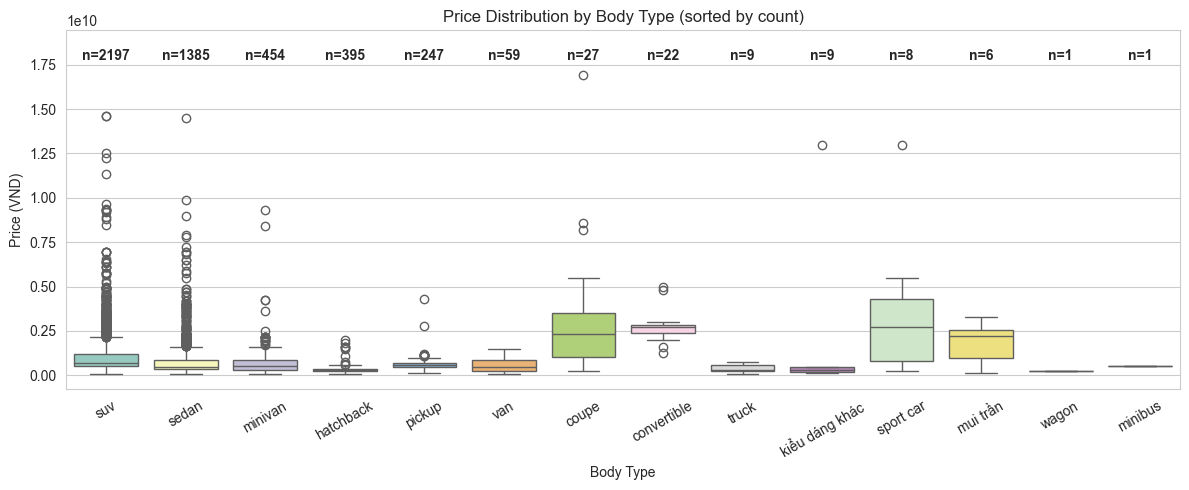

In [74]:
body_order = df["body"].value_counts().index

plt.figure(figsize=(12,5))

ax = sns.boxplot(
    x="body",
    y="price",
    data=df,
    order=body_order,
    palette="Set3"
)

plt.title("Price Distribution by Body Type (sorted by count)")
plt.xlabel("Body Type")
plt.ylabel("Price (VND)")
plt.xticks(rotation=30)

counts = df["body"].value_counts()
y_max = df["price"].max()

for i, body in enumerate(body_order):
    ax.text(
        i,
        y_max * 1.05,
        f"n={counts[body]}",
        ha="center",
        fontsize=10,
        fontweight="bold"
    )

plt.ylim(top=y_max * 1.15)
plt.tight_layout()
plt.show()

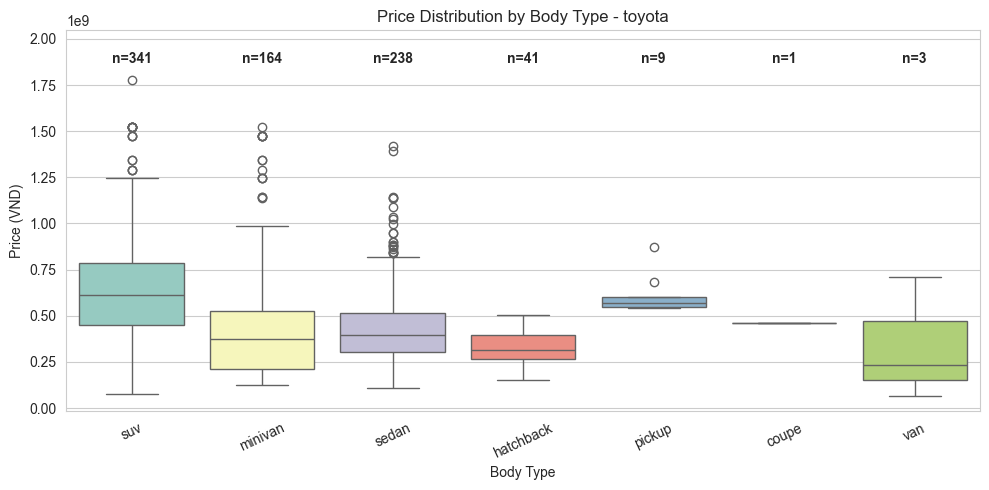

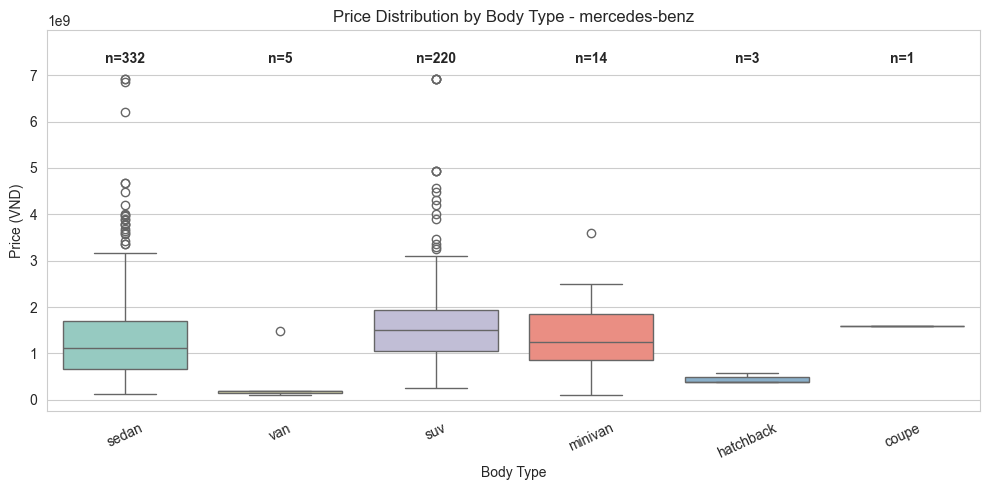

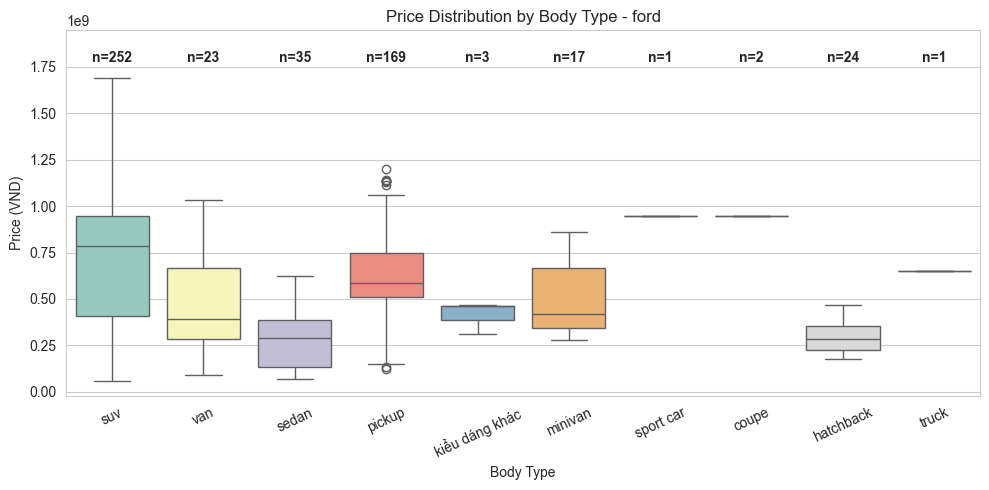

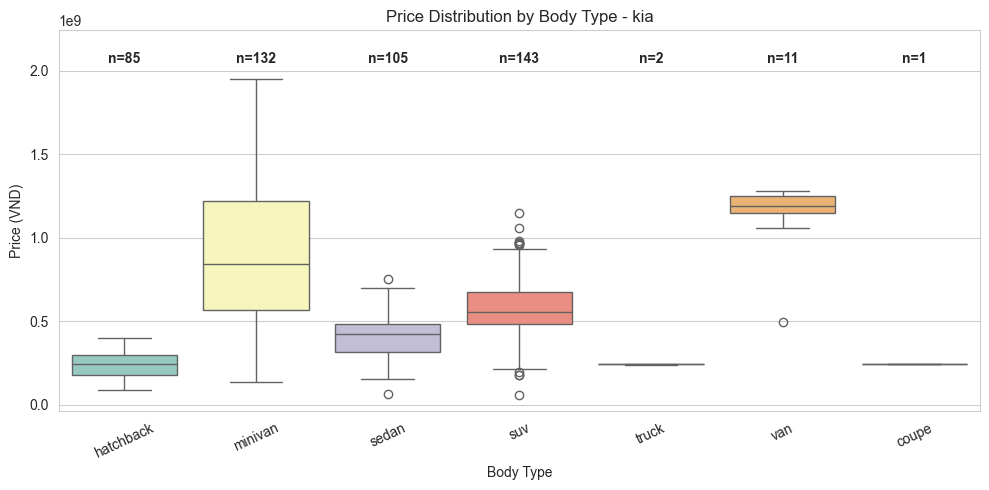

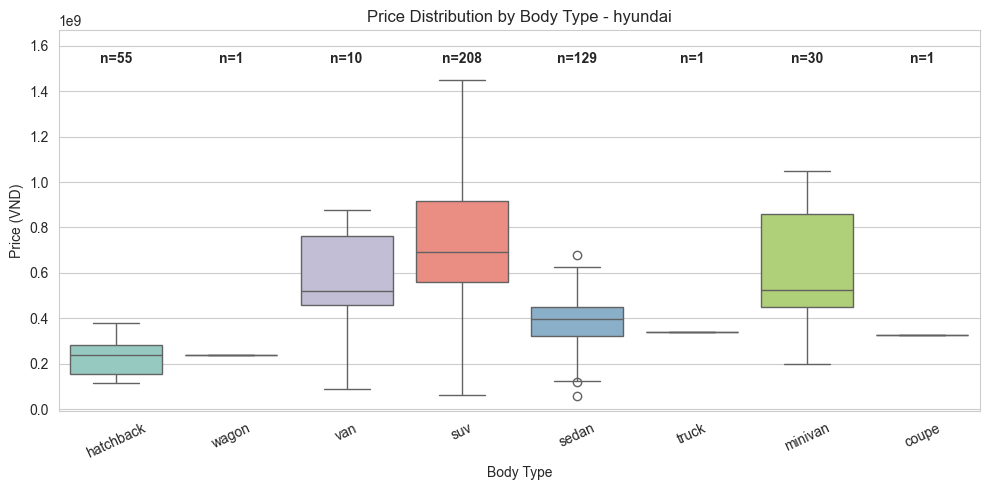

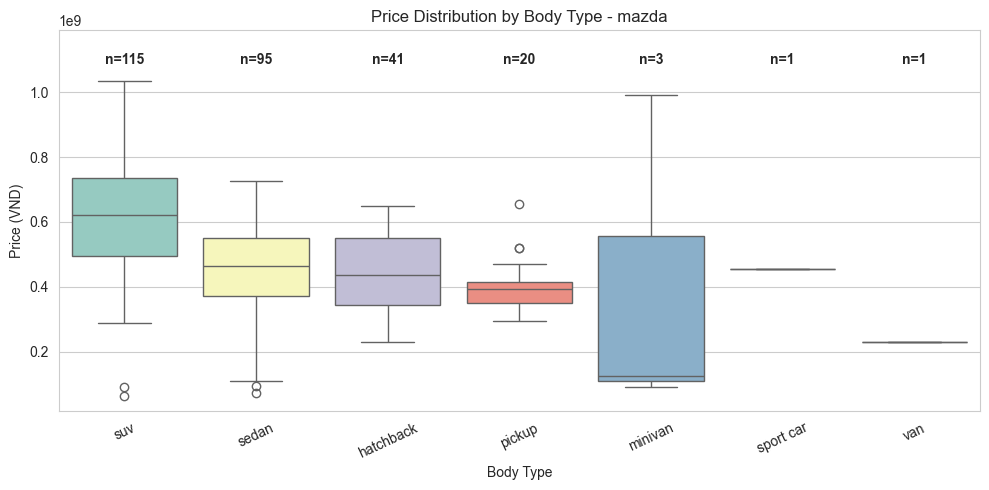

In [72]:
top_brands = df["brand"].value_counts().head(6).index

for brand in top_brands:
    df_b = df[df["brand"] == brand]

    plt.figure(figsize=(10,5))
    
    ax = sns.boxplot(
        x="body",
        y="price",
        data=df_b,
        palette="Set3"
    )

    plt.title(f"Price Distribution by Body Type - {brand}")
    plt.xlabel("Body Type")
    plt.ylabel("Price (VND)")
    plt.xticks(rotation=25)

    counts = df_b["body"].value_counts()
    y_max = df_b["price"].max()

    for i, body in enumerate(ax.get_xticklabels()):
        body_name = body.get_text()
        ax.text(
            i,
            y_max * 1.05,
            f"n={counts[body_name]}",
            ha="center",
            fontsize=10,
            fontweight="bold"
        )

    plt.ylim(top=y_max * 1.15)
    plt.tight_layout()
    plt.show()
